# Task 1

Here we will see how our nn and autograd works.

Also we will review some Catalyst's abstractions, implement callbacks and datasets.

Unfortunately, python is slow, and implementing dynamic computational graph in pure python for product-ready solution is not a good idea. But this task will help you to understand what's happening when you call `backward` method for variable or tensor. Also it will help you in learning Catalyst framework and will teach how you to write your code in more Catalyst-like way.

In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from nn import Linear, ReLU, CrossEntropyLoss, Module, Sigmoid
from optim import SGD
from engine import Value, Tensor
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Defining toy dataset

To be more human-readable and easy to understand, we want to store every data in key-value format.

So, the dataset should yield dict, moreover we will store train/valid datasets in a dict.

In [63]:
class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, item):
        return {"features": X[item], "targets": y[item]}

    def __len__(self):
        return len(self.y)



X, y = make_moons(200, noise=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)# Split data to Train and Valid
datasets = {"train": Dataset(X_train, y_train), "valid": Dataset(X_val, y_val)}

Take a look on a data.

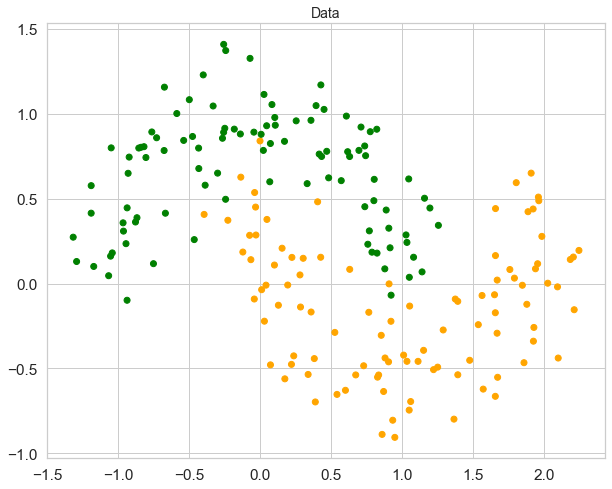

In [3]:
plt.figure(figsize=(10, 8))
plt.title("Data", fontsize=14)
colors = list(map(lambda x: "green" if x ==0 else "orange", y))
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.show()

### Model

Let's define our model in PyTorch-style. But don't forget to implement `parameters()` method.

In [4]:
class SimpleModel(Module):
    def __init__(self):
        self.linear_1 = Linear(2, 5)
        self.relu_1 = ReLU()
        self.linear_2 = Linear(5, 1)
        self.sigmoid = Sigmoid()

    def forward(self, inp):
        out = self.linear_1(inp)
        out = self.relu_1(out)
        out = self.linear_2(out)
        out = self.sigmoid(out)
        return out

    def parameters(self):
        params = []
        params.extend(self.linear_1.parameters())
        params.extend(self.linear_2.parameters())
        return params

## For loop

Let's start with simple train/test loop.

In [5]:
def _to_one_hot(targets, n_classes=2):
    targets = np.array([targets]).reshape(-1)
    one_hot_targets = np.eye(n_classes)[targets]
    return Tensor(one_hot_targets[:, 1:])

def pre_process_batch(batch):
    features = Tensor(np.array([sample['features']for sample in batch]))
    targets = _to_one_hot([sample['targets'] for sample in batch])
    return features, targets

In [17]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.1)

num_epochs = 100
batch_size = 4
log_period = 5
for epoch in range(num_epochs):
    current_batch = []
    metrics = {}
    for k, dataset in datasets.items():
        loader_metrics = {}
        epoch_loss = 0
        epoch_accuracy = 0
        for idx, data in enumerate(dataset):
            last = idx == (len(dataset)-1)
            current_batch.append(data)
            if last or len(current_batch) == batch_size:
                features, targets = pre_process_batch(current_batch)
                current_batch = []
                prediction = model(features)
                loss = criterion(prediction, targets)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

In [15]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = model(Tensor(np.array(inputs)))#list(map(model, np.array(inputs)))
scores = np.array([sample[0] for sample in scores])
scores_0 = [1 - sample for sample in scores]
# scores = np.array([sample[0].data for sample in scores])

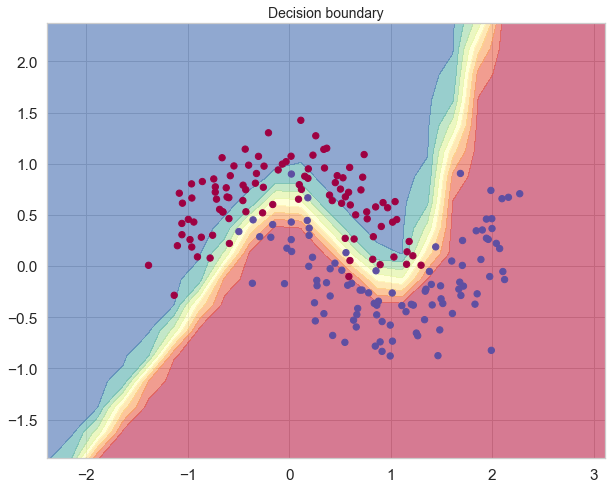

In [16]:
Z = np.array([s[1].exp().data/(s[0].exp()+s[1].exp()).data for s in zip(scores, scores_0)])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 8))
plt.title("Decision boundary", fontsize=14)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


## General training loop - Catalyst intro - Runner¶

Code above can be reused for almost all machine learning task. Let's take a look on experiment structure

```
for stage in stage:
    for epoch in epochs:
        for loader on loaders:
            for batch in loader:
                # do something
```

### Runner

In most cases we only need to adapt our batch handling method. And here comes the Runner.

Runner is the main part of your experiment. It runs train loop, calls callbacks (we will discusds them later) and keeps track on your model. And the only thing you need to change is _handle_batch method.


In [6]:
from tqdm.notebook import tqdm
from sklearn import metrics 

class Runner:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        datasets,
        batch_size
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.datasets = datasets

        self.batch_size = batch_size

        self.input = {}
        self.output = {}
        self.batch_metrics = {}
        self.loader_metrcis = {}
        self.epoch_metrics = {'train': {},
                              'valid': {}}

    def _handle_batch(self, batch, train=True):
        """
        Stores the main logic of data aggregating.
        """
        threshold = 0.5 
        features, targets = pre_process_batch(batch)
        prediction = model(features)
        loss = criterion(prediction, targets)
        if train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        loss = loss[0].data
        
        pred = np.array([pred.data for pred in prediction[:, 0]]) > 0.5
        ground_truth = np.array([sample.data for sample in targets[:, 0]])
        accuracy = metrics.accuracy_score(ground_truth, pred) 

        self.batch_metrics = {"loss": loss, "accuracy": accuracy}


    def train(self, num_epochs: int = 100, verbose=False):
        for epoch in range(num_epochs):
#             self.epoch_metrics = {}
            self.epoch = epoch
            for dataset_name, dataset in self.datasets.items():
                self.dataset_name = dataset_name
                self.loader_metrics = {}
                current_batch = []

                if verbose:
                    iter_ = tqdm(enumerate(dataset), total=len(dataset))
                else:
                    iter_ = enumerate(dataset)

                for idx, data in iter_:
                    last = idx == (len(dataset)-1)
                    current_batch.append(data)

                    if last or len(current_batch) == self.batch_size:
                        # Handle batch
                        self._handle_batch(current_batch)
                        current_batch = []

                        for k, v in self.batch_metrics.items():
                            if k not in self.loader_metrics:
                                self.loader_metrics[k] = []
                            self.loader_metrics[k].append(v)
                
                for metric, value in self.loader_metrics.items():
                    value = np.mean(self.loader_metrics[metric])
                    self.loader_metrics[metric] = value
                    if metric not in self.epoch_metrics[self.dataset_name]:
                        self.epoch_metrics[self.dataset_name][metric] = []
                    self.epoch_metrics[self.dataset_name][metric].append(value)

### Run training

In [15]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.1)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=3,
)
runner.train(100, False)

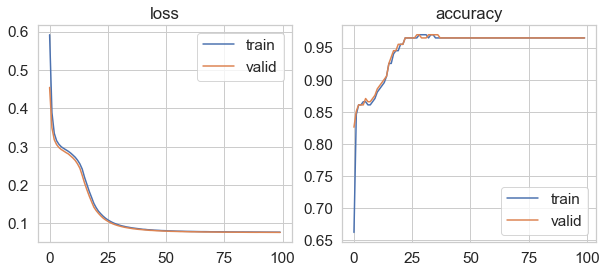

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(runner.epoch_metrics['train']['loss'], label='train')
plt.plot(runner.epoch_metrics['valid']['loss'], label='valid')
plt.legend()
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(runner.epoch_metrics['train']['accuracy'], label='train')
plt.plot(runner.epoch_metrics['valid']['accuracy'], label='valid')
plt.legend()
plt.title('accuracy')
plt.show()

### Visualization

In [17]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = model(Tensor(np.array(inputs)))#list(map(model, np.array(inputs)))
scores = np.array([sample[0] for sample in scores])
scores_0 = [1 - sample for sample in scores]
# scores = np.array([sample[0].data for sample in scores])

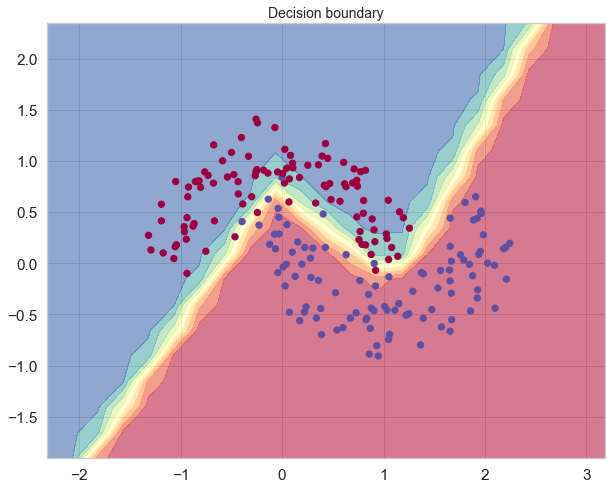

In [18]:
Z = np.array([s[1].exp().data/(s[0].exp()+s[1].exp()).data for s in zip(scores, scores_0)])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 8))
plt.title("Decision boundary", fontsize=14)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


## General training loop - Catalyst intro - Callbacks

But could we make it even more general? Should we rewrite loss.backward or compute accuracy again and again? Do we really need it?

I don't think so, I think, we could introduce another general abstaction for typical train-loop logic. Let's introduce Callbacks!

### Callbacks

In catalyst callbacks have significant impact in everything you do.
Let's try to implement some of them.

There are a list of moments, where callbacks can be integrated. We will need only three of them.
```
on_stage_start
    on_epoch_start
        on_loader_start
            on_batch_start
------->    on_batch_end
----->  on_loader_end
--> on_epoch_end
on_stage_end
```

In [34]:
class Callback:
    def on_stage_start(self):
        pass

    def on_stage_end(self):
        pass

    def on_epoch_start(self):
        pass

    def on_epoch_end(self, runner):
        pass

    def on_loader_start(self):
        pass

    def on_loader_end(self, runner):
        pass

    def on_batch_start(self):
        pass

    def on_batch_end(self, runner):
        pass


class LossCallback(Callback):
    """
    Aggregating loss value.
    """
    def __init__(self):
        self.cum_loss = 0
        self.num_batches = 0

    def on_batch_end(self, runner):
        """
        On batch end action.

        Accumulates loss and num batches.

        Args:
            output: dict with loss and other model's outputs.
        """
        self.cum_loss += runner.output["loss"][0].data
        self.num_batches += 1

    def on_loader_end(self, runner):
        """
        On loader end action.

        Args:
            epoch_metrics: dict with epoch metrics

        Returns:
            loss over the loader.
        """
        runner.epoch_metrics["loss"] = self.cum_loss / self.num_batches
        self.cum_loss = 0
        self.num_batches = 0


class AccuracyCallback(Callback):
    """
    Aggregating accuracy value.
    """
    def __init__(self):
        self.accuracy = []

    def on_batch_end(self, runner):
        """
        On batch end action

        Accumulates number of correct predictions.

        Args:
            output: dict with number of the correct predictions
        """
        prediction = runner.output['prediction']
        pred = np.array([pred.data for pred in prediction[:, 0]]) > 0.5
        ground_truth = np.array([sample.data for sample in runner.input[1][:, 0]])
        self.accuracy.append(metrics.accuracy_score(ground_truth, pred))

    def on_loader_end(self, runner):
        """
        On loader end action.

        Args:
            epoch_metrics: dict with epoch metrics

        Returns:
            accuracy value over the loader.
        """
        runner.epoch_metrics["accuracy"] = np.mean(self.accuracy)
        self.accuracy = []


class LoggerCallback(Callback):
    """
    Log metrics to output.
    """
    def __init__(self, log_period):
        self.log_period = log_period

    def on_epoch_end(self, runner):
        """
        On epoch end action.

        Prints all epoch metrics if log_period is suitable.

        Args:
            epoch_metrics: dict with epoch metrics
            epoch: current epoch
        """
        if runner.epoch % self.log_period == 0:
            log_string = f"Epoch: {runner.epoch}\n"
            for metric, value in runner.epoch_metrics.items():
                log_string += f'metric {metric}: {value}'# Logging all metrics
            print(log_string)


class OptimizerCallback(Callback):
    def on_batch_start(self, runner):
        if runner.dataset_name == "train":
            # Reset gradients
            optimizer.zero_grad()

    def on_batch_end(self, runner):
#         runner.output['loss'].back
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         for data, outp in zip(runner.input, runner.output):
#             current_loss = runner.criterion(outp, data["targets"])
#             loss += current_loss
        
#         loss = loss / len(runner.input)
        
        if runner.dataset_name == "train":
            runner.output['loss'].backward()
            optimizer.step()
            optimizer.zero_grad()

In [35]:
from tqdm.notebook import tqdm


class Runner:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        datasets,
        batch_size,
        callbacks,
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.datasets = datasets

        self.batch_size = batch_size
        self.callbacks = callbacks
        
        self.input = {}
        self.output = {}
        self.batch_metrics = {}
        self.loader_metrcis = {}
        self.epoch_metrics = {}

    def _handle_batch(self, batch):
        """
        Stores the main logic of data aggregating.
        """
        batch = pre_process_batch(batch)
        prediction = model(batch[0])
        loss = self.criterion(prediction, batch[1])
        self.input = batch
        self.output = {'prediction': prediction, 'loss': loss}


    def train(self, num_epochs: int = 100, verbose=False):
        for epoch in range(num_epochs):
            self.epoch_metrics = {}
            self.epoch = epoch
            for dataset_name, dataset in self.datasets.items():
                self.dataset_name = dataset_name
                self.loader_metrics = {}
                current_batch = []

                if verbose:
                    iter_ = tqdm(enumerate(dataset), total=len(dataset))
                else:
                    iter_ = enumerate(dataset)

                for idx, data in iter_:
                    last = idx == (len(dataset)-1)
                    current_batch.append(data)

                    if last or len(current_batch) == self.batch_size:
                        for clb_name, clb in self.callbacks.items():
                            if clb_name == 'optimizer':
                                clb.on_batch_start(self)
                            else:
                                clb.on_batch_start()
                            
                        self._handle_batch(current_batch)
                        # Handle batch
                        
                        current_batch = []

                        for clb in self.callbacks.values():
                            clb.on_batch_end(self)

                for clb in self.callbacks.values():
                    clb.on_loader_end(self)

### Run training

In [53]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.08)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=3,
    callbacks={
        "loss": LossCallback(),
        "accuracy": AccuracyCallback(),
        "logger": LoggerCallback(log_period=5),
        "optimizer": OptimizerCallback(),
    }
)
runner.train(50)

In [54]:
runner.epoch_metrics

{'loss': 0.11404007249743403, 'accuracy': 0.9751243781094526}

### Visualization

In [55]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = model(Tensor(np.array(inputs)))#list(map(model, np.array(inputs)))
scores = np.array([sample[0] for sample in scores])
scores_0 = [1 - sample for sample in scores]
# scores = np.array([sample[0].data for sample in scores])

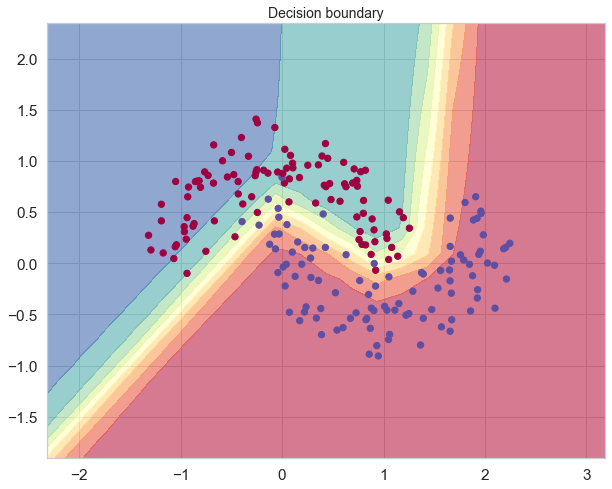

In [56]:
Z = np.array([s[1].exp().data/(s[0].exp()+s[1].exp()).data for s in zip(scores, scores_0)])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 8))
plt.title("Decision boundary", fontsize=14)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

## MNIST

Try to train model on MNIST task!

In [65]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [ ]:
class MNISTDataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return {"features": ..., "targets": ...}

    def __len__(self):
        return len(self.y)

# Python is slow, that's why we use only small group of object
datasets = {
    "train": MNISTDataset(X_train[:2000], y_train[:2000]),
    "valid": MNISTDataset(X_val[:200], y_val[:200])
} 

In [ ]:
class MnistModel(Module):
    def __init__(
        self,
        inp_shape=28*28,
        out_shape=10,
        hidden_shapes=[10, 10]
    ):
        # Create your model!

    def forward(self, inp):
        return ...

    def parameters(self):
        parameters = [] # Don't forget about parameters!
        return parameters

In [ ]:
criterion = CrossEntropyLoss()
model = MnistModel()
optimizer = SGD(model.parameters(), lr=0.1)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=16,
    callbacks={
        "loss": LossCallback(),
        "accuracy": AccuracyCallback(),
        "logger": LoggerCallback(log_period=1),
        "optimizer": OptimizerCallback(),
    }
)
runner.train(5, verbose=True)